## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `Chart Generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。
3. [**可选**]优化研究智能体 `Researcher` 提示词和路由函数 `route` 跳转逻辑，提升图表生成的成功率。

## **HW-02**
**2.将 Chart Generator 替换为其他功能智能体（如 table_generator），为其设计提示词，然后运行查看生成结果。**

In [ ]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"


### **1.辅助函数：创建智能体**

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


### **2.定义工具**

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### **3.辅助函数：智能体节点**

In [ ]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

### **为 Agent 配置各自的大模型**

In [ ]:

research_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
chart_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### **4. 定义 研究智能体及其节点**

In [ ]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="Before using the search engine, carefully think through and clarify the query. "
    "Then, conduct a single search that addresses all aspects of the query in one go.",  # 系统消息，指导智能体如何使用搜索工具
)

# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### **5. 定义 图表生成器智能体及其节点**

In [ ]:
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Create clear and user-friendly charts based on the provided data.",  # 系统消息，指导智能体如何生成图表
)

# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

### **6. 导入预构建的工具节点**

In [ ]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

### **7. 建立智能体节点间通信 AgentState**

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str

### **8. 定义工作流（状态图）**

In [ ]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

# 定义路由函数
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"

# 定义条件边逻辑
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Chart Generator",  # 如果 router 返回 "continue"，则传递到 Chart Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Chart Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Chart Generator": "Chart Generator",  # 如果 sender 是 Chart Generator，则返回给 Chart Generator
    },
)

# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

### **9. 执行工作流**

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


## **HW03**
**3.[可选]优化研究智能体 Researcher 提示词和路由函数 route 跳转逻辑，提升图表生成的成功率。**

In [1]:
# 导入环境变量
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("MOONSHOT_API_KEY")
_set_if_undefined("ZHIPUAI_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"


### **1.辅助函数：创建智能体**

In [2]:
# 创建智能体的构建函数，设置prompt
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                #" If you or any of the other assistants have the final answer or deliverable,"（此次注释后，解决research抛出final answer的问题）
                # " prefix your response with FINAL ANSWER so the team knows to stop."（**此次注释后，解决research抛出final answer的问题**）
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


### **2.定义工具**

In [3]:
# 定义工具

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### **3.辅助函数：智能体节点**

### **agent_node代码优化：**

#### **原来代码：**

```python

# 辅助函数：智能体节点
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }
```


#### **主要优化点：**
- **报错：**
  ```bash
  BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages[12].name': string does not match pattern. Expected a string that matches the pattern '^[a-zA-Z0-9_-]+$'.", 'type': 'invalid_request_error', 'param': 'messages[12].name', 'code': 'invalid_value'}}
  ```
  <br>
- **分析:**

  **根据报错信息，问题出在 messages[12].name 上，它的值不符合预期的正则表达式模式 ^[a-zA-Z0-9_-]+$，这通常是因为智能体生成的某个消息中的 name 字段包含了不合法的字符。**

  从报错分析来看，问题主要集中在以下几方面：
    - messages 中的 name 字段
    <br>错误提示表明，messages[12].name 字段的值未能匹配预期的模式。根据错误消息，name 字段应仅包含字母、数字、下划线 (_) 或横杠 (-)。<br>
    - 智能体生成的 name 值不合法
    <br>在 agent_node 函数中，我们为每个智能体的输出结果生成了一个 name。可能这个 name 包含了不合法的字符，导致请求失败。<br>
    - 问题可能的根源：
    <br>在代码中，我们是通过 agent_node 函数为每个智能体的输出添加了 name：
    <br>这里可能的问题是，在 result = AIMessage(**result.dict(exclude={"type", "name"}), name=name) 这一行，生成的 name 可能包含了非法字符，比如空格或特殊字符。<br>

- **解决：**
  确保 name 的合法性： 在生成 name 时，确保它只包含字母、数字、下划线和横杠。您可以使用 Python 的正则表达式或字符串替换方法来移除或替换非法字符。

In [4]:
# 优化后代码：
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

import re

def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 确保 name 字段只包含合法字符（字母、数字、下划线、横杠）
    valid_name = re.sub(r'[^a-zA-Z0-9_-]', '_', name)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并使用合法的 name 值
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=valid_name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        "sender": valid_name,
    }


### **为 Agent 配置各自的大模型**

In [5]:

research_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
chart_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### **4. 定义 研究智能体及其节点**

### **research提示词优化**

#### **源代码：**
```python
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="Before using the search engine, carefully think through and clarify the query. "
    "Then, conduct a single search that addresses all aspects of the query in one go.",  # 系统消息，指导智能体如何使用搜索工具
)
```
#### **优化reseacher的提示词:**

```python
research_agent = create_agent(
    research_llm,
    [tavily_tool],  # Researcher 使用 Tavily 搜索工具
    system_message=(
        "You are responsible for searching and gathering information based on user queries. "
        "Before using the search engine, carefully think through and clarify the query. "
        "If the query only requests factual data or information (e.g., GDP values), "
        "provide the result and mark it as FINAL ANSWER. "
        "However, if the query suggests further steps such as data processing or chart generation, "
        "pass the result to the next agent, such as the Chart Generator, without providing FINAL ANSWER. "
        "The system will determine if further actions are necessary."
    )
)
```


In [6]:
# 使用优化后的提示词
research_agent = create_agent(
    research_llm,
    [tavily_tool],  # Researcher 使用 Tavily 搜索工具
    system_message=(
        "You are responsible for searching and gathering information based on user queries. "
        "Before using the search engine, carefully think through and clarify the query. "
        "If the query only requests factual data or information (e.g., GDP values), "
        "provide the result and mark it as FINAL ANSWER. "
        "However, if the query suggests further steps such as data processing or chart generation, "
        "pass the result to the next agent, such as the Chart Generator, without providing FINAL ANSWER. "
        "The system will determine if further actions are necessary."
    )
)

In [7]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### **5. 定义 图表生成器智能体及其节点**

In [8]:
# 图表生成器智能体及其节点
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Your role is to delegate the task of generating charts based on the provided data by utilizing the available tools (e.g., Python REPL). "
    "You should not generate the chart directly yourself, but instead call the appropriate tool to do so. "
    "If the chart is successfully generated and no further steps are required, you can mark the result as FINAL ANSWER. "
    "However, if additional processing is needed, pass the result to the next agent without marking it as FINAL ANSWER.",  # 修改后的系统消息，明确任务是调用工具生成图形
)


In [9]:
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

### **6. 导入预构建的工具节点**

In [10]:
# 导入预购件 ToolNode
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

### **7. 建立智能体节点间通信 AgentState**

In [11]:
# 建立智能体节点间通信AgentState
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str

### **8. 定义工作流（状态图）**

In [12]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("call_tool", tool_node)

In [13]:
# 定义路由函数
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


In [14]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Chart_Generator",  # 如果 router 返回 "continue"，则传递到 Chart Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Chart_Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体,x相当于是state
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Chart_Generator": "Chart_Generator",  # 如果 sender 是 Chart Generator，则返回给 Chart Generator
    },
)


In [15]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

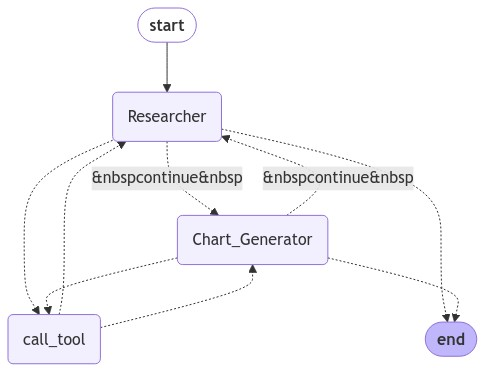

In [16]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

### **9. 执行工作流**

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_lDa1zJ2jtBp4f7P1ND5xjHPF)
 Call ID: call_lDa1zJ2jtBp4f7P1ND5xjHPF
  Args:
    query: GDP of the United States from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "content": "U.S. gdp for 2021 was $23,315.08B, a 10.71% increase from 2020. U.S. gdp for 2020 was $21,060.47B, a 1.5% decline from 2019. U.S. gdp for 2019 was $21,380.98B, a 4.13% increase from 2018. GDP at purchaser's prices is the sum of gross value added by all resident producers 

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: Chart_Generator
Tool Calls:
  python_repl (call_YkUxLtKztkau2RZhSwvpB1iu)
 Call ID: call_YkUxLtKztkau2RZhSwvpB1iu
  Args:
    code: import matplotlib.pyplot as plt

# Data for GDP from 2000 to 2020
years = list(range(2000, 2021))
gdp_values = [10250.00, 10580.00, 10600.00, 10900.00, 11300.00,
    12000.00, 12600.00, 13100.00, 14000.00, 14200.00,
    14600.00, 15100.00, 15500.00, 16000.00, 16800.00,
    17300.00, 17700.00, 18100.00, 18600.00, 21000.00,
    21060.47]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion USD')
plt.xticks(years)  # Set x-ticks to be every year
plt.grid()
plt.show()


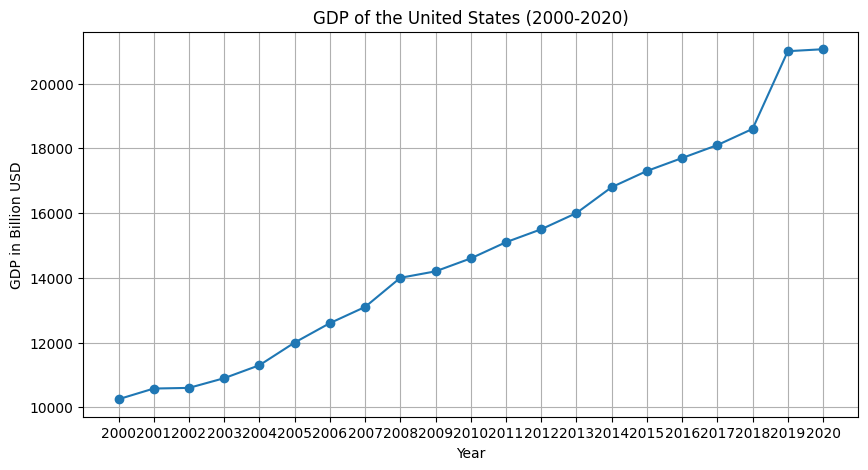

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

# Data for GDP from 2000 to 2020
years = list(range(2000, 2021))
gdp_values = [10250.00, 10580.00, 10600.00, 10900.00, 11300.00,
    12000.00, 12600.00, 13100.00, 14000.00, 14200.00,
    14600.00, 15100.00, 15500.00, 16000.00, 16800.00,
    17300.00, 17700.00, 18100.00, 18600.00, 21000.00,
    21060.47]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion USD')
plt.xticks(years)  # Set x-ticks to be every year
plt.grid()
plt.show()
```
Stdout: 

If you have completed all tasks, respond with FINAL ANSWER.
================================== Ai Message ==================================
Name: Chart_Generator

The line chart showing the GDP of the United States from 2000 to 2020 has been successfull

In [17]:
# 执行工作流
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容
